<a href="https://colab.research.google.com/github/jimzhang629/RippleNet/blob/master/edited_RippleNet_training_bidirectional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RippleNet_training_bidirectional
Training of simple bidirectional recurrent neural network (RNN) implementation in `tensorflow.keras` using LSTM (long short-term memory) units to identify time of occurence of sharp wave ripple (SPW-R) events in temporal data.

Author: Espen Hagen (<https://github.com/espenhgn>)

LICENSE: <https://github.com/CINPLA/RippleNet/blob/master/LICENSE>

In [ ]:
# allow running on Google Colab for training using Google Drive for file access
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/My\ Drive/RippleNet
    %tensorflow_version 2.x
except:
    pass

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/RippleNet'
/content/gdrive/My Drive/RippleNet


In [ ]:
%matplotlib inline

In [ ]:
import os
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import ripplenet.models
import h5py
import pickle
import random

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10815165131168978088
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15703311680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6900730861814852409
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [ ]:
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.4.1
/device:GPU:0
Num GPUs Available:  1


In [ ]:
# set random seeds with some additional environment variables to ensure deterministic output
random_seed = 497
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED']=str(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
# select dataset (may have generated different sets.)
dataset_index = 0 

# Load training/validation data

In [ ]:
# select species for training/validation data (mouse, rat or both)
mouse = True
rat = False

In [ ]:
# output destination
output_folder = 'trained_networks'
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

# prefix for trained network files (training loss/MSE, weights, `best' weights)
rnn_prefix = 'ripplenet_bidirectional'

In [ ]:
if mouse:
    # training and validation files
    f_name_train = 'train_{:02}.h5'
    f_name_val = 'validation_{:02}.h5'

    # training data
    f = h5py.File(os.path.join('data',  
                               f_name_train.format(dataset_index)), 
                  'r')
    X_train = np.expand_dims(f['X0'][:], -1)
    Y_train = f['Y'][:]
    f.close()

    # validation data
    f = h5py.File(os.path.join('data', 
                               f_name_val.format(dataset_index)), 
                  'r')
    X_val = np.expand_dims(f['X0'][:], -1)
    Y_val = f['Y'][:]
    f.close()

    # load some data for plotting
    f = h5py.File(os.path.join('data',
                               f_name_val.format(dataset_index)), 'r')
    X0 = f['X0'][:]
    X1 = f['X1'][:]
    S = f['S'][:]
    Y = f['Y'][:]
    S_freqs = f['S_freqs'][:]
    f.close()

In [ ]:
def prime_factors(n):
    i = 2
    factors = []
    while i * i <= n:
        if n % i:
            i += 1
        else:
            n //= i
            factors.append(i)
    if n > 1:
        factors.append(n)
    return factors

In [ ]:
print(X_train.shape[0])
print("prime factorization of X_train[0] * X_train[1] :", prime_factors(X_train.shape[0]*X_train.shape[1]))
print("prime factorization of X_val[0] * X_val[1] :", prime_factors(X_val.shape[0]*X_val.shape[1]))
print("The common factors are: 1, 2, 5, 10, 25, 50, 125, 250, 625, 1250, 3125, 6250, 15625, 31250")

4175
prime factorization of X_train[0] * X_train[1] : [2, 5, 5, 5, 5, 5, 5, 167]
prime factorization of X_val[0] * X_val[1] : [2, 2, 2, 2, 5, 5, 5, 5, 5, 5]
The common factors are: 1, 2, 5, 10, 25, 50, 125, 250, 625, 1250, 3125, 6250, 15625, 31250


In [ ]:
samples_per_time_segment = 625 #how many samples per each time segment. Some combination of the prime factors.
time_segment = samples_per_time_segment / 1250 #how many seconds are the time segments we're training on
train_first_dim = int(X_train.shape[0]*X_train.shape[1] / samples_per_time_segment) #must make sure that this is evenly divisible
val_first_dim = int(X_val.shape[0]*X_val.shape[1] / samples_per_time_segment)
print(val_first_dim)
print(time_segment)

400
0.5


In [ ]:
reshaped_X_train = np.reshape(X_train, (train_first_dim, samples_per_time_segment, 1))
reshaped_Y_train = np.reshape(Y_train, (train_first_dim, samples_per_time_segment, 1))
reshaped_X_val = np.reshape(X_val, (val_first_dim, samples_per_time_segment, 1))
reshaped_Y_val = np.reshape(Y_val, (val_first_dim, samples_per_time_segment, 1))
#print(reshaped_X_train)
print(reshaped_X_train.shape)
print(reshaped_Y_train.shape)

print(reshaped_X_val.shape)
print(reshaped_Y_val.shape)

(8350, 625, 1)
(8350, 625, 1)
(400, 625, 1)
(400, 625, 1)


In [ ]:
# Add rat training/validation data to sets
if rat and mouse:
    # rat 
    f_name_train = 'train_tingley_{:02}.h5'
    f_name_val = 'validation_tingley_{:02}.h5'

    # training data
    f = h5py.File(os.path.join('data', 
                            f_name_train.format(dataset_index)), 
                'r')
    X_train = np.concatenate((X_train, np.expand_dims(f['X0'][:], -1)))
    Y_train = np.concatenate((Y_train, f['Y'][:]))
    f.close()

    # validation data
    f = h5py.File(os.path.join('data',  
                            f_name_val.format(dataset_index)), 
                'r')
    X_val = np.concatenate((X_val, np.expand_dims(f['X0'][:], -1)))
    Y_val = np.concatenate((Y_val, f['Y'][:]))
    f.close()

    # load some data for plotting
    f = h5py.File(os.path.join('data',
                            f_name_val.format(dataset_index)), 'r')
    X0 = np.concatenate((X0, f['X0'][:]))
    X1 = np.concatenate((X1, f['X1'][:]))
    S = np.concatenate((S, f['S'][:]))
    Y = np.concatenate((Y, f['Y'][:]))
    f.close()

In [ ]:
if rat and not mouse:
    # rat 
    f_name_train = 'train_tingley_{:02}.h5'
    f_name_val = 'validation_tingley_{:02}.h5'

    # training data
    f = h5py.File(os.path.join('data',  
                               f_name_train.format(dataset_index)), 
                  'r')
    X_train = np.expand_dims(f['X0'][:], -1)
    Y_train = f['Y'][:]
    f.close()

    # validation data
    f = h5py.File(os.path.join('data', 
                               f_name_val.format(dataset_index)), 
                  'r')
    X_val = np.expand_dims(f['X0'][:], -1)
    Y_val = f['Y'][:]
    f.close()

    # load some data for plotting
    f = h5py.File(os.path.join('data', 
                               f_name_val.format(dataset_index)), 'r')
    X0 = f['X0'][:]
    X1 = f['X1'][:]
    S = f['S'][:]
    Y = f['Y'][:]
    S_freqs = f['S_freqs'][:]
    f.close()

In [ ]:
# needed parameters
Fs = 1250 # Hz, sampling freq
time = np.arange(X0.shape[1]) / Fs

# center raw data
X0 = (X0.T - X0.mean(axis=-1)).T

# total number of samples
n_samples = X0.shape[0]

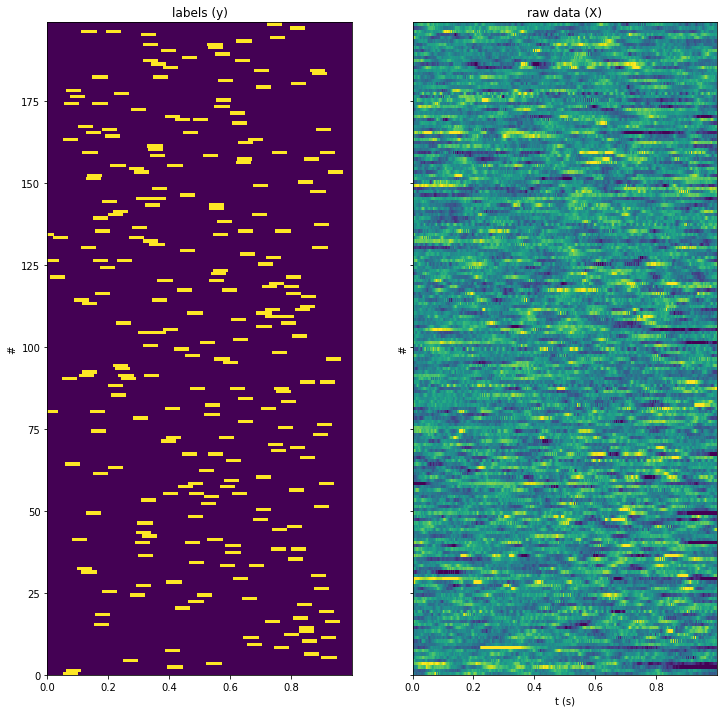

In [ ]:
# plot all labels and raw data matrices
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 12))
axes[0].pcolormesh(time, np.arange(n_samples), Y[:, :, 0])
axes[0].set_ylabel('#')
axes[0].set_title('labels (y)')
axes[1].pcolormesh(time, np.arange(n_samples), X0, vmin=-X0.std()*3, vmax=X0.std()*3)
axes[1].set_ylabel('#')
axes[1].set_xlabel('t (s)')
axes[1].set_title('raw data (X)')
for ax in axes:
    ax.axis(ax.axis('tight'))

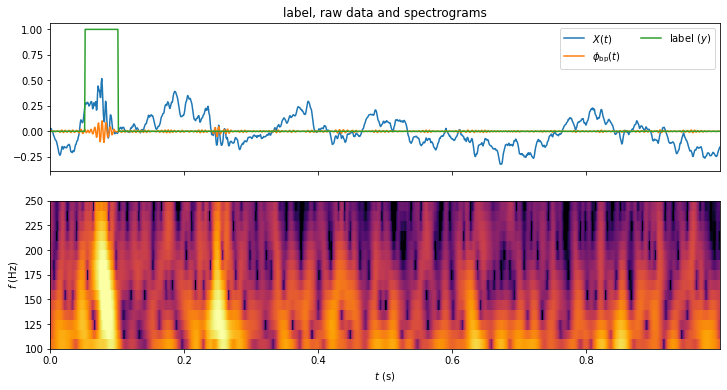

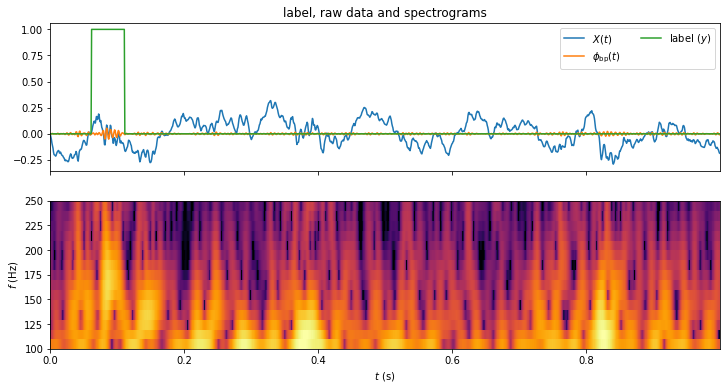

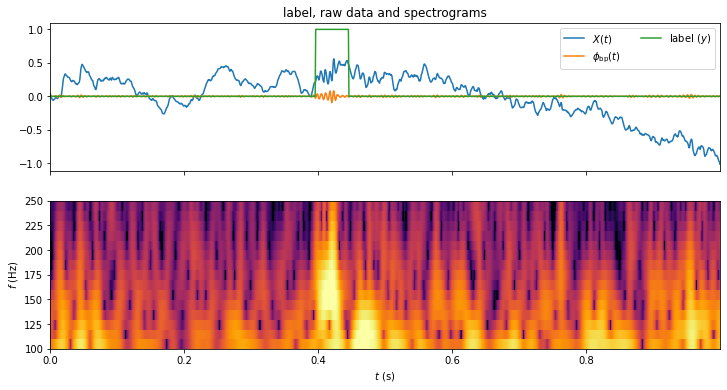

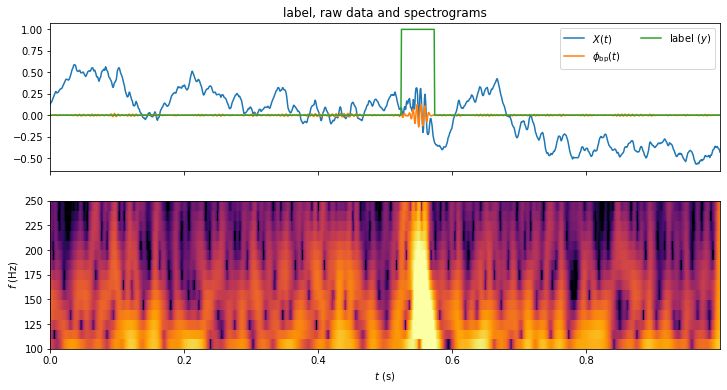

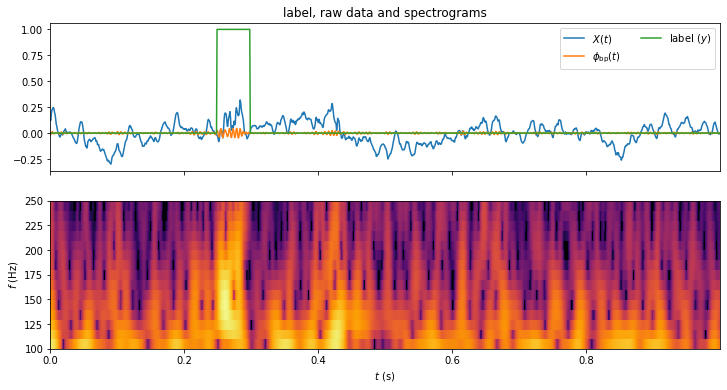

In [ ]:
# plot wavelet spectrograms vs. labels and raw data for some samples
for i in range(5):
    gs = GridSpec(2, 1)
    fig = plt.figure(figsize=(12, 6))
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(time, X0[i, ], label='$X(t)$')
    ax0.plot(time, X1[i, ], label=r'$\phi_\mathrm{bp}(t)$')
    ax0.plot(time, Y[i, :, 0], label='label ($y$)' )
    ax0.legend(ncol=2)
    ax0.axis(ax0.axis('tight'))
    ax0.set_title('label, raw data and spectrograms')
    plt.setp(ax0.get_xticklabels(), visible=False)
    
    ax1 = fig.add_subplot(gs[1:, 0], sharex=ax0)
    vmin, vmax = np.exp(np.percentile(np.log(S), [1, 99]))
    im = ax1.pcolormesh(time, S_freqs, S[i, ].T, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                        cmap='inferno')
    ax1.axis(ax1.axis('tight'))
    ax1.set_ylabel('$f$ (Hz)')
    ax1.set_xlabel('$t$ (s)')

# Set up recurrent neural network

In [ ]:
model = ripplenet.models.get_bidirectional_LSTM_model(input_shape=(None, reshaped_X_train.shape[2]), 
                                                      layer_sizes=[10, 20, 20, 20],
                                                      seed=random_seed+1)


In [ ]:
model.summary()

Model: "RippleNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 10)          110       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 10)          40        
_________________________________________________________________
dropout (Dropout)            (None, None, 10)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 20)          2220      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 20)          80

In [ ]:
# plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
# model checkpoints when validation mse improves
filepath = os.path.join(output_folder, '{}_best_random_seed{}.h5'.format(rnn_prefix, random_seed))
checkpoint_best = keras.callbacks.ModelCheckpoint(filepath, monitor='val_mse', 
                                             verbose=1, save_best_only=True, 
                                             mode='min')
callback_hist = keras.callbacks.CSVLogger(os.path.join(output_folder, '{}_history_random_seed{}.csv'.format(rnn_prefix, random_seed)))
callbacks_list = [checkpoint_best, callback_hist]

In [ ]:
# train model
history = model.fit(reshaped_X_train, reshaped_Y_train, 
                    batch_size=20, 
                    epochs=50, 
                    callbacks=callbacks_list,
                    validation_data=(reshaped_X_val, reshaped_Y_val))

Epoch 1/50
418/418 [==============================] - 44s 93ms/step - loss: 0.2359 - mse: 0.0713 - val_loss: 0.1990 - val_mse: 0.0485

Epoch 00001: val_mse improved from inf to 0.04847, saving model to trained_networks/ripplenet_bidirectional_best_random_seed497.h5
Epoch 2/50
418/418 [==============================] - 38s 91ms/step - loss: 0.1077 - mse: 0.0312 - val_loss: 0.0888 - val_mse: 0.0274

Epoch 00002: val_mse improved from 0.04847 to 0.02738, saving model to trained_networks/ripplenet_bidirectional_best_random_seed497.h5
Epoch 3/50
418/418 [==============================] - 38s 91ms/step - loss: 0.0978 - mse: 0.0285 - val_loss: 0.0713 - val_mse: 0.0218

Epoch 00003: val_mse improved from 0.02738 to 0.02175, saving model to trained_networks/ripplenet_bidirectional_best_random_seed497.h5
Epoch 4/50
418/418 [==============================] - 38s 91ms/step - loss: 0.0850 - mse: 0.0246 - val_loss: 0.0667 - val_mse: 0.0203

Epoch 00004: val_mse improved from 0.02175 to 0.02026, savi

In [ ]:
# save history to a pickle so we can load it later
with open(os.path.join(output_folder, '{}_history_random_seed{}.pkl'.format(rnn_prefix, random_seed)), 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
plt.figure(figsize=(12, 12))
plt.semilogy(history.history['loss'], '-o', label='loss')
plt.semilogy(history.history['val_loss'], '-o', label='val_loss')
plt.semilogy(history.history['mse'], '-o', label='mse')
plt.semilogy(history.history['val_mse'], '-o', label='val_mse')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('training/validation MSE')

In [ ]:
# Save the trained model
model.save(os.path.join(output_folder, '{}_random_seed{}.h5'.format(rnn_prefix, random_seed)))